# Credit Card Fraud Detection
This notebook is dedicated to the study and prediction of credit card fraud from a large transaction dataset.

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff

cmap = [sns.color_palette('hls')[0], sns.color_palette('hls')[4]]

data = arff.loadarff('data/dataset.arff')

df = pd.DataFrame(data[0])
df.insert(1, 'Amount', df.pop('Amount'))
df['Class'] = df['Class'].apply(lambda x: int(x))

In [241]:
print('Total number of NULL values:', df.isna().sum().sum())

Total number of NULL values: 0


## A look at the data
***
- attributes
- summary statistics
- class distribution

In [242]:
df.head()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [243]:
df.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,88.349619,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,0.001727
std,47488.145955,250.120109,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,5.600000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,84692.000000,22.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,139320.500000,77.165000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,172792.000000,25691.160000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


In [244]:
print('Size of dataset: {} samples'.format(len(df)))
print('% dataset with class 0: {}\n% dataset with class 1: {}\n'.format(len(df.loc[df['Class'] == 0]) / len(df) * 100, len(df.loc[df['Class'] == 1]) / len(df) * 100))

Size of dataset: 284807 samples
% dataset with class 0: 99.82725143693798
% dataset with class 1: 0.1727485630620034



## Exploratory Data Analysis
***

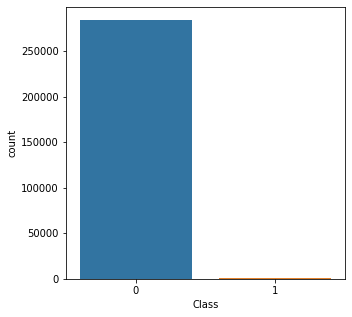

In [245]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x='Class', data=df)

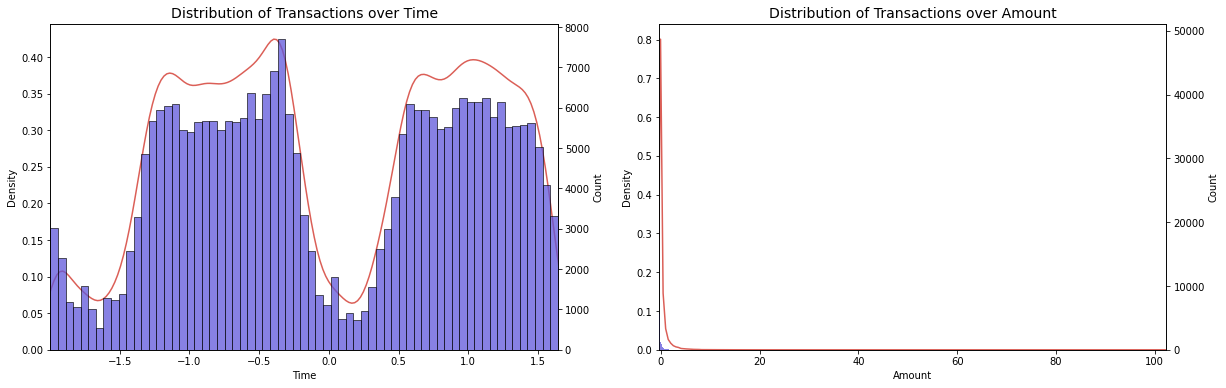

In [265]:
def amount_time_distributions(df):
    _, ax = plt.subplots(1, 2, figsize=(20, 6))
    sns.kdeplot(x='Time', ax=ax[0], data=df, color=cmap[0])
    ax2 = ax[0].twinx()
    sns.histplot(x='Time', ax=ax2, data=df, color=cmap[1])
    ax[0].set_title('Distribution of Transactions over Time', fontsize=14)
    ax[0].set_xlim([min(df['Time']), max(df['Time'])])
    
    sns.kdeplot(x='Amount', ax=ax[1], data=df, color=cmap[0])
    ax2 = ax[1].twinx()
    sns.histplot(x='Amount', ax=ax2, data=df, color=cmap[1])
    ax[1].set_title('Distribution of Transactions over Amount', fontsize=14)
    ax[1].set_xlim([min(df['Amount']), max(df['Amount'])])

    plt.show()

amount_time_distributions(df)

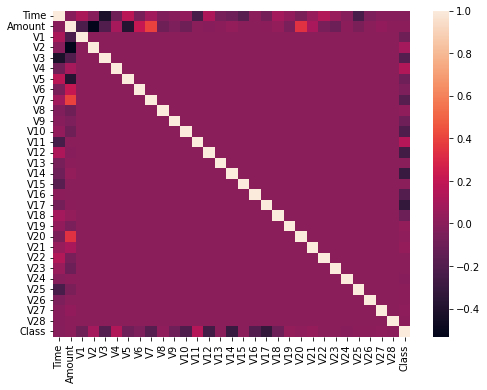

In [247]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(df.corr())

In [248]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

df[['Time', 'Amount']] = scale.fit_transform(df[['Time', 'Amount']])

In [249]:
df.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,2.913952e-17,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,0.001727
std,1.000002e+00,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,-1.996583e+00,-3.532294e-01,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-8.552120e-01,-3.308401e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,-2.131453e-01,-2.652715e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,9.372174e-01,-4.471707e-02,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,1.642058e+00,1.023622e+02,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


In [250]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(labels=['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_nonfraud_len = len(np.where(y_train == 0)[0])
train_fraud_len = len(np.where(y_train == 1)[0])

test_nonfraud_len = len(np.where(y_test == 0)[0])
test_fraud_len = len(np.where(y_test == 1)[0])

print('TRAINING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(train_fraud_len, train_nonfraud_len))
print('% trainset with class 0: {}\n% trainset with class 1: {}\n'.format(train_nonfraud_len / len(y_train) * 100, train_fraud_len / len(y_train) * 100))

print('TESTING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(test_fraud_len, test_nonfraud_len))

print('% testset with class 0: {}\n% testset with class 1: {}\n'.format(test_nonfraud_len / len(y_test) * 100, test_fraud_len / len(y_test) * 100))

TRAINING SET
- Fraud class size: 394
- Non-Fraud class size: 227451
% trainset with class 0: 99.82707542408215
% trainset with class 1: 0.17292457591783889

TESTING SET
- Fraud class size: 98
- Non-Fraud class size: 56864
% testset with class 0: 99.82795547909133
% testset with class 1: 0.17204452090867595



In [251]:
new_df = pd.concat([X_train, y_train], axis=1)
holdout_df = pd.concat([X_test, y_test], axis=1)

In [252]:
new_df = new_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(train_fraud_len))

Distribution of the Classes with Random Undersampling
0    0.5
1    0.5
Name: Class, dtype: float64


Text(0.5, 1.0, 'Balanced Dataset')

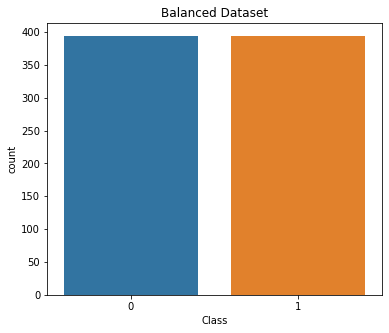

In [253]:
print('Distribution of the Classes with Random Undersampling')
print(new_df['Class'].value_counts()/len(new_df))

fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Class', data=new_df)
plt.title('Balanced Dataset')

### Correlation Matrix
***
- I wanted to see how the features are correlated. When checking their respective correlations to the Class (Fraudulent or Non-Fraudulent), we notice that features V1-V18 have the strongest correlations.
- Although features like V21 and V22 are strongly negatively correlated, neither seems to be correlated to the Class in any particular way, so this information alone may not be directly useful for predicting the class. 
- I will focus visualizations on the features which have the weak $\rightarrow$ strong correlation with the Class (<= -0.65 or >= 0.5):
    - The specific intervals were chosen to get even samples from both positively and negatively correlated features.

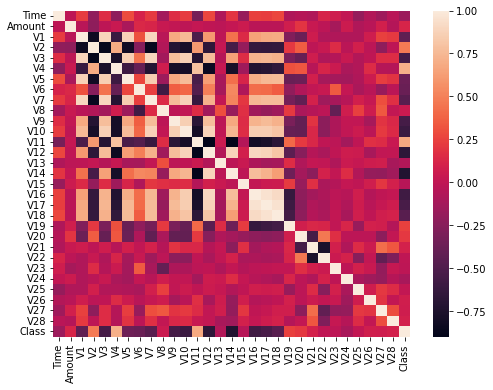

In [254]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(new_df.corr())

In [255]:
class_corr = new_df.corr()['Class']
pos_corr = class_corr.loc[(class_corr >= 0.6)].iloc[:-1]
neg_corr = class_corr.loc[(class_corr <= -0.65)]

In [256]:
for idx in pos_corr.index:
    print(idx, pos_corr[idx])
    
for idx in neg_corr.index:
    print(idx, neg_corr[idx])

V4 0.709474589673882
V11 0.6807218603367259
V12 -0.6720045621965551
V14 -0.735579482293564


In [257]:
new_df.loc[new_df['Class'] == 1, 'Class Name'] = 'Fraud'
new_df.loc[new_df['Class'] == 0, 'Class Name'] = 'Non-Fraud'
new_df['Class Name'] = new_df['Class Name'].astype('category')
new_df['Class Dist'] = d['Value']

zero_class_dist = np.random.normal(loc=0, scale=0.1, size=len(new_df)//2)
one_class_dist = np.random.normal(loc=1, scale=0.1, size=len(new_df)//2)

new_df.loc[new_df['Class'] == 0, 'Class Dist'] = zero_class_dist
new_df.loc[new_df['Class'] == 1, 'Class Dist'] = one_class_dist

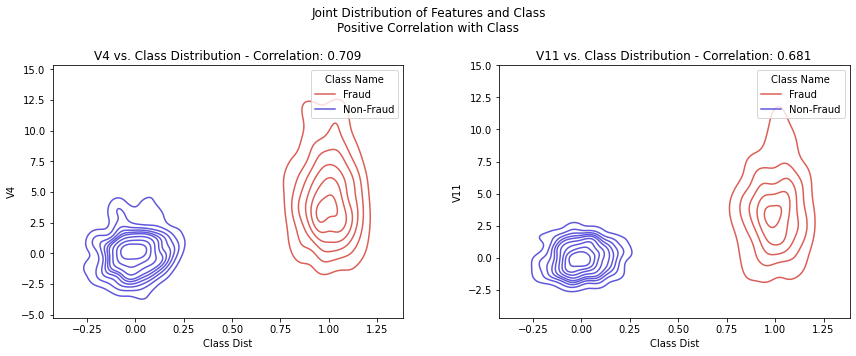

In [258]:
fig, axs = plt.subplots(1, len(pos_corr), figsize=(6*len(pos_corr), 5))
for i, feat in enumerate(pos_corr.index):
    sns.kdeplot(data=new_df, x='Class Dist', y=feat, ax=axs[i], hue='Class Name', palette=cmap)
    axs[i].set_title('{} vs. Class Distribution - Correlation: {}'.format(feat, round(pos_corr[feat], 3)))
    plt.suptitle('Joint Distribution of Features and Class\nPositive Correlation with Class')

plt.tight_layout(w_pad=5.0)
plt.show()

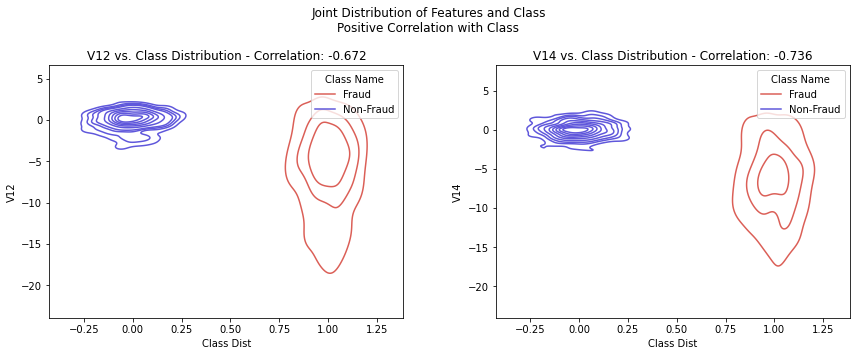

In [259]:
fig, axs = plt.subplots(1, len(neg_corr), figsize=(6*len(neg_corr), 5))
for i, feat in enumerate(neg_corr.index):
    sns.kdeplot(data=new_df, x='Class Dist', y=feat, ax=axs[i], hue='Class Name', palette=cmap)
    axs[i].set_title('{} vs. Class Distribution - Correlation: {}'.format(feat, round(neg_corr[feat], 3)))
    plt.suptitle('Joint Distribution of Features and Class\nPositive Correlation with Class')

plt.tight_layout(w_pad=5.0)
plt.show()

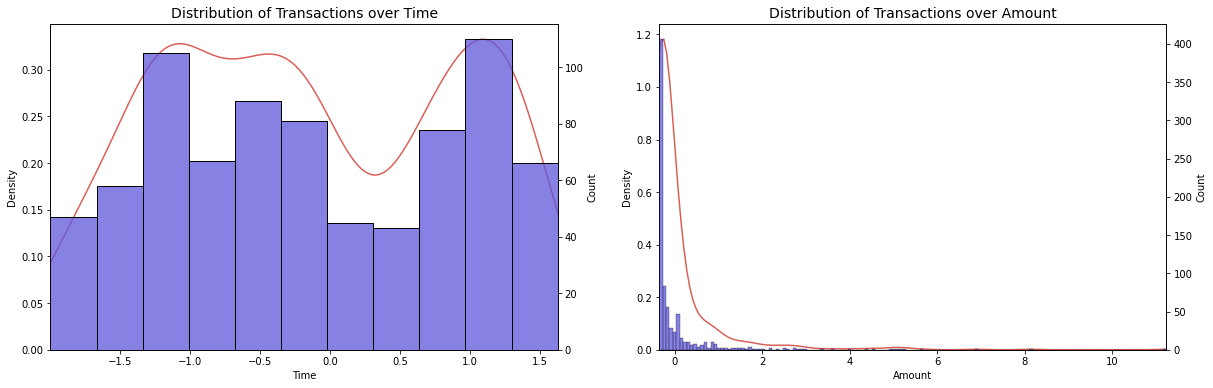

In [266]:
amount_time_distributions(new_df)

In [261]:
'''# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))'''

"# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)\nv14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values\nq25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)\nprint('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))\nv14_iqr = q75 - q25\nprint('iqr: {}'.format(v14_iqr))\n\nv14_cut_off = v14_iqr * 1.5\nv14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off\nprint('Cut Off: {}'.format(v14_cut_off))\nprint('V14 Lower: {}'.format(v14_lower))\nprint('V14 Upper: {}'.format(v14_upper))\n\noutliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]\nprint('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))\nprint('V10 outliers:{}'.format(outliers))\n\nnew_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)\nprint('----' * 44)\n\n# -----> V12 removing outliers from fraud transactions\nv12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values\nq25, q75 = np.percentile(v12_fraud, 

In [262]:
threshold = 1.5
lower_quartile = df.quantile(0.25)
upper_quartile = df.quantile(0.75)
interquartile_range = upper_quartile - lower_quartile

lower_bound = lower_quartile - threshold * interquartile_range
upper_bound = upper_quartile + threshold * interquartile_range

df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.996583,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-1.996583,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
3,-1.996562,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.996541,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-1.996541,-0.338556,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284796,1.641805,-0.113344,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,...,-0.153997,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0
284797,1.641847,-0.331280,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,...,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0
284800,1.641889,-0.342515,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,...,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0
284801,1.641910,-0.342475,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,...,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,0


In [263]:
'''f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()'''

'f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))\n\ncolors = [\'#B3F9C5\', \'#f9c5b3\']\n# Boxplots with outliers removed\n# Feature V14\nsns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)\nax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)\nax1.annotate(\'Fewer extreme \n outliers\', xy=(0.98, -17.5), xytext=(0, -12),\n            arrowprops=dict(facecolor=\'black\'),\n            fontsize=14)\n\n# Feature 12\nsns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)\nax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)\nax2.annotate(\'Fewer extreme \n outliers\', xy=(0.98, -17.3), xytext=(0, -12),\n            arrowprops=dict(facecolor=\'black\'),\n            fontsize=14)\n\n# Feature V10\nsns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)\nax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)\nax3.annotate(\'Fewer extreme \n outliers\', xy=(0.95, -16.5), xytext=(0, -12),\n            arr

C:\Users\chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


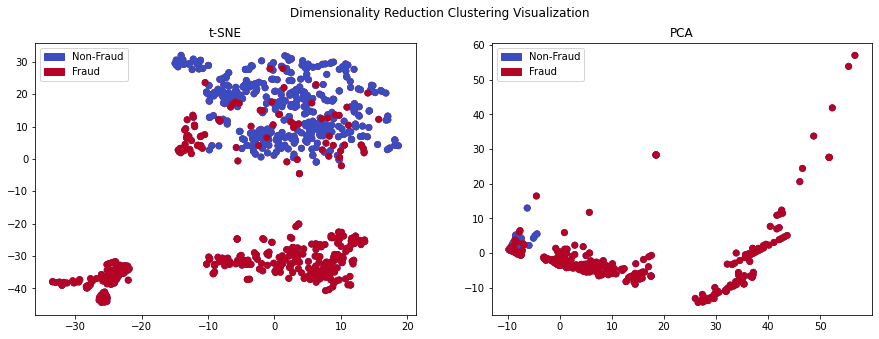

In [268]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Dimensionality Reduction Clustering Visualization')

nonfraud_patch = mpatches.Patch(color='#3b4cc0', label='Non-Fraud')
fraud_patch = mpatches.Patch(color='#b40426', label='Fraud')

X = new_df.drop(['Class', 'Class Name', 'Class Dist'], axis=1)
y = new_df['Class']

X_tsne = TSNE(n_components=2, learning_rate='auto', perplexity=40).fit_transform(X)
axs[0].scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
axs[0].scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
axs[0].set_title('t-SNE')
axs[0].legend(handles=[nonfraud_patch, fraud_patch])

X_pca = PCA(n_components=2).fit_transform(X)
axs[1].scatter(X_pca[:, 0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
axs[1].scatter(X_pca[:, 0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
axs[1].set_title('PCA')
axs[1].legend(handles=[nonfraud_patch, fraud_patch])


plt.show()


III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>


correlating
<a id="correlating"></a>
